# Importing TensorFlow and Numpy

In [ ]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
K = 110
r = 0.05
sigma = 0.2

## Initial Condition

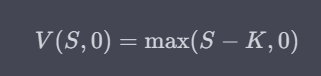

##Boundary condition

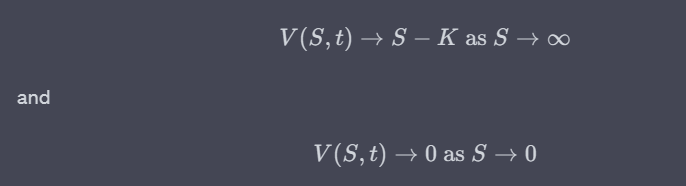

## 1D BS equation

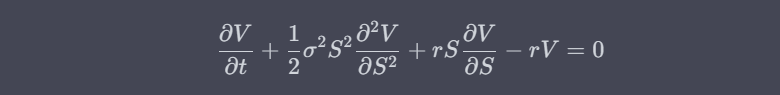

In [ ]:
# X = [[x1,y1],[x2,y2],[x3,y3]]
def U_0(x): # Define initial condition
    K = 110
    return tf.maximum(x-K,0)
    # return 0.5*tf.exp(-1*tf.reduce_mean(tf.square(x),axis = 1)/0.01) #gaussian fuction

def U_b(t, x): # Define boundary condition
    K = 110
    r= 0.05
    return tf.where(x>0,x-K*(np.exp(-r*t)),0)
    # x[t] = x[t] - K
    # return x
    # return tf.zeros((1,x.shape[0]), dtype='float32')

def PDE(t, x, u, u_t, u_x, u_xx): # Defining PDE to solve
    # Set constants
    K = 110
    r = 0.05
    sigma = 0.2
    return u_t + (1/2)*(sigma**2)*x*x*u_xx + r*x*u_x - r*u
    # return (u_t - tf.reshape(tf.linalg.trace(u_xx),(-1,1)))  # Take trace because u_xx will be on diagonal in hessian matrix

# Plotting to see the initial condition plot

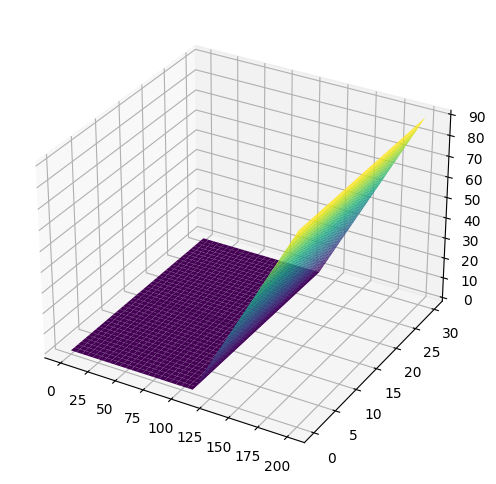

In [ ]:
N = 200
T = 30
x_space = np.linspace(0, 200, N + 1)
t_space = np.linspace(0, T, N + 1)
X1, X2 = np.meshgrid(x_space, t_space)
Xgrid = np.vstack([X1.flatten()]).T
Xgrid = tf.convert_to_tensor(Xgrid)
upred = np.array(U_0(Xgrid)).reshape(N+1,N+1)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2,upred, cmap='viridis');

# $Setting$ $(t,x)$ $Boundry$ $Values$

In [ ]:
# Set boundary
tmin = tf.constant(0.0, dtype='float32')
tmax = tf.constant(T, dtype='float32')

# Here we will be providing in mulit diminsinal form # Xmin = [[x1min,x2min]], Xmax = [[x1max,x2max]]
xmin = tf.constant([[0]], dtype='float32')
xmax = tf.constant([[200]], dtype='float32')

#  $Genrating$ $Random$ $points$ $from$ $Uniform$ $Distibution$

In [ ]:
# Set number of data points
N_0 = 100    ## Initial Condition
N_b = 100    ## Boundry Condition
N_i = 1000 ## Collocation points

# Set random seed for reproducible results
tf.random.set_seed(0)

- Draw uniform sample points for Initial Condition

In [ ]:
t_0 = tf.ones((N_0,1), dtype='float32')*tmax
x_0 = tf.stack([tf.random.uniform((N_0,), xmin[0][i], xmax[0][i], dtype='float32') for i in range(xmin.shape[1])],axis = 1)
X_0 = tf.concat([t_0, x_0], -1)

# Evaluate intitial condition at x_0
u_0 = U_0(x_0)

- Draw uniform sample points for Boundary Condition

In [ ]:
t_b = tf.random.uniform((N_b,1), tmin, tmax, dtype='float32')

x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((N_b,xmin.shape[1]), 0.5, dtype='float32')  ## Time can be anything (X= [+1,+1],[+1,-1],[-1,+1],[-1,-1] )
X_b = tf.concat([t_b, x_b], -1)

# # Evaluate boundary condition at (t_b,x_b)
u_b = U_b(t_b, x_b)

- Draw uniform sample Collocation Points

In [ ]:
t_i = tf.random.uniform((N_i,1), tmin, tmax, dtype='float32')
x_i = tf.stack([tf.random.uniform((N_i,), xmin[0][i], xmax[0][i], dtype='float32') for i in range(xmin.shape[1])],axis = 1)
X_i = tf.concat([t_i, x_i], -1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

# Plotting Data Generated

Fix x_b

<ipython-input-11-44fcfef4ad63>:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(t_0, x_0[:,0], c='blue', marker='X', vmin=-1, vmax=1)
<ipython-input-11-44fcfef4ad63>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(t_b, x_b[:,0], c='green', marker='X', vmin=-1, vmax=1)


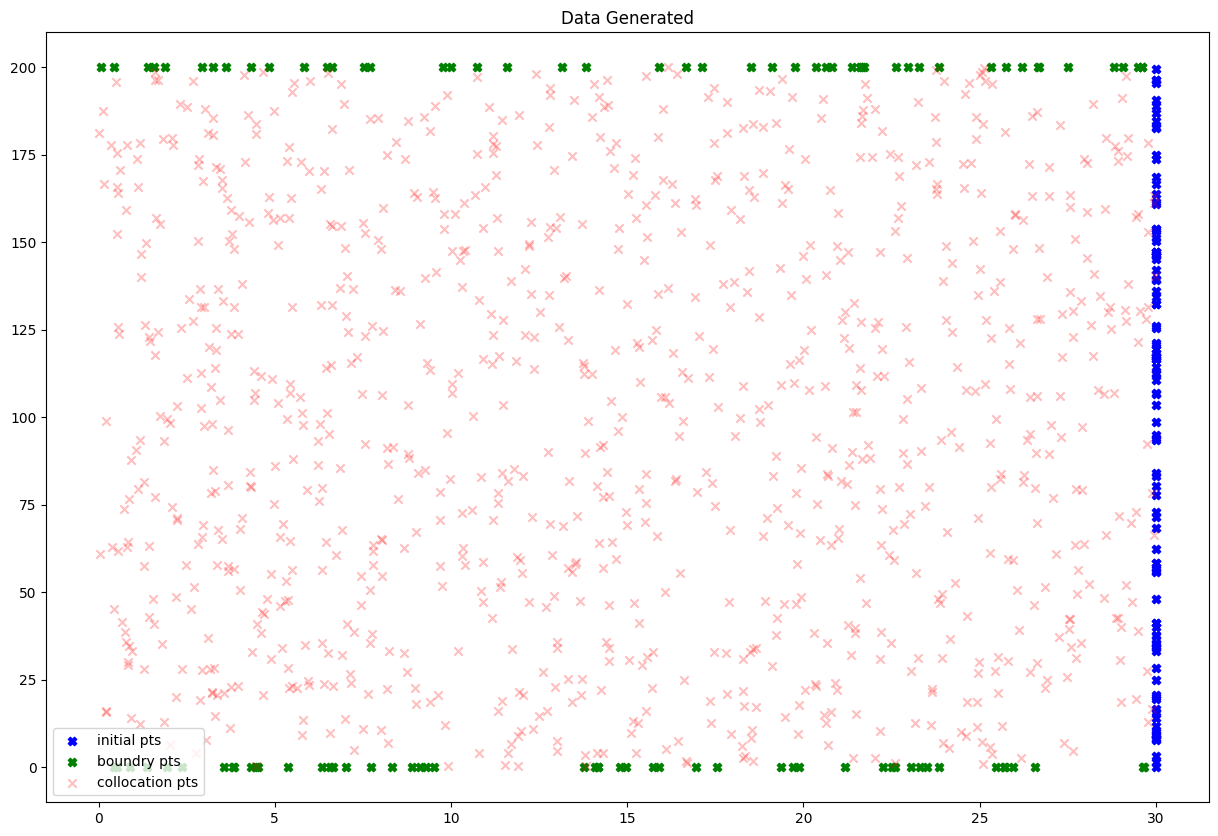

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,10))
# ax = fig.add_subplot(projection='3d')
plt.scatter(t_0, x_0[:,0], c='blue', marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b[:,0], c='green', marker='X', vmin=-1, vmax=1)
plt.scatter(t_i, x_i[:,0], c='red', marker='x',alpha=0.25)
# plt.xlabel('t',fontsize=15)
# plt.ylabel('x',fontsize=15)
plt.legend(["initial pts","boundry pts","collocation pts"])

plt.title('Data Generated');

# Defining the Neural Network

In [ ]:
def init_model(num_dims = 1,num_hidden_layers=4, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(1 + num_dims))

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh')))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

# *Calculating U, U<sub>$x$</sub>, U<sub>$t$</sub> ,U<sub>$xx$</sub> for PDE*

In [ ]:
def get_pde(model, X_i):

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    # Persistent = True because, if false then tape gets deleted after one gradient calculation

    with tf.GradientTape(persistent=True) as t2:
      t, x = X_i[:,0:1], X_i[:,1::]
      t2.watch(t)
      t2.watch(x)
      with tf.GradientTape(persistent=True) as t1:
        # Variables t and x are watched during tape to compute derivatives u_t and u_x
        t1.watch(t)
        t1.watch(x)
        # Determine residual
        u = model(tf.concat([t, x], -1))

      # Compute gradient u_x within the GradientTape since we need second derivatives
      u_x = t1.gradient(u, x)
    u_t = t1.gradient(u, t)
    u_xx = t2.batch_jacobian(u_x, x) # calculating the hessian matrix
    del t1
    del t2
    return PDE(t, x, u, u_t, u_x, u_xx)

$
\mathbf{H}_f(\mathbf{x}_\mathbf{A}) = \begin{pmatrix}
\dfrac{\partial^2 f}{\partial {x_1}^2}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial^2 f}{\partial x_1\, \partial x_2}(\mathbf{x}_\mathbf{A})\\
\dfrac{\partial^2 f}{\partial x_2\,\partial x_1}(\mathbf{x}_\mathbf{A})
&& \dfrac{\partial^2 f}{\partial {x_2}^2}(\mathbf{x}_\mathbf{A})\\
\end{pmatrix}
$

# Computing The Loss Fuction for the PDE
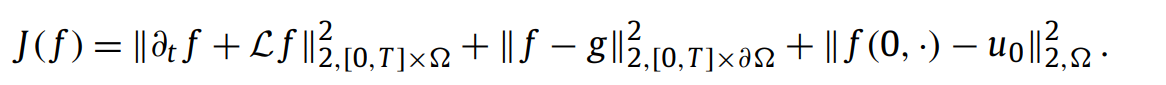

In [ ]:
def compute_loss(model, X_i, X_data, u_data):

    # Compute L_r (Residual Loss)
    pde = get_pde(model, X_i)
    L_r = tf.reduce_mean(tf.square(pde))

    # Initialize loss
    loss = L_r

    # Add L_0 and L_b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

    return loss

# Getting Gradients for Trainable Neural Network Parameters

In [ ]:
def get_grad(model, X_i, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_i, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

# Initializing Model and Optimizer

In [ ]:
# Initialize model
model = init_model(num_dims = 1)

# Choose the optimizer

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000,6000],[1e-2,1e-3,5e-4,5e-5])
optim = tf.keras.optimizers.Adam(learning_rate=lr)

# Training the Model

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_i, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    return loss

# Number of training epochs
N = 10000
hist = []

# Start timer
t0 = time()

for i in range(N+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 100 iterates
    if i%200 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.16955967e+04
It 00200: loss = 5.51562549e+03
It 00400: loss = 2.84442310e+03
It 00600: loss = 1.47685461e+03
It 00800: loss = 8.99786865e+02
It 01000: loss = 6.67050171e+02
It 01200: loss = 6.20386475e+02
It 01400: loss = 6.03483032e+02
It 01600: loss = 5.88013977e+02
It 01800: loss = 5.73501465e+02
It 02000: loss = 5.59915405e+02
It 02200: loss = 5.47713013e+02
It 02400: loss = 5.35669983e+02
It 02600: loss = 5.23479126e+02
It 02800: loss = 4.93985901e+02
It 03000: loss = 4.82465027e+02
It 03200: loss = 4.74151917e+02
It 03400: loss = 4.67289032e+02
It 03600: loss = 5.41622131e+02
It 03800: loss = 4.68126160e+02
It 04000: loss = 4.54347168e+02
It 04200: loss = 5.39660583e+02
It 04400: loss = 4.50527527e+02
It 04600: loss = 4.44678833e+02
It 04800: loss = 5.11329224e+02
It 05000: loss = 4.42192261e+02
It 05200: loss = 5.36951660e+02
It 05400: loss = 3.23474274e+02
It 05600: loss = 2.28650055e+02
It 05800: loss = 2.25045441e+02
It 06000: loss = 2.01048004e+02
It 06200

# Plotting the Partial Differential Equation

In [ ]:
import numpy as np
from scipy.stats import norm

def U(S,t):
    K = 110
    r = 0.05
    sigma = 0.2
    T = 30
    """
    Computes the price of a European call option using the Black-Scholes formula.

    Parameters:
        S (float): current price of the underlying asset
        K (float): strike price of the option
        T (float): time to maturity of the option (in years)
        r (float): risk-free interest rate
        sigma (float): volatility of the underlying asset

    Returns:
        float: price of the European call option
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
    call_price = S*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
    return call_price

<ipython-input-18-dd0d8b242ff7>:22: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*(T-t)) / (sigma*np.sqrt(T-t))
<ipython-input-18-dd0d8b242ff7>:22: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*(T-t)) / (sigma*np.sqrt(T-t))
<ipython-input-18-dd0d8b242ff7>:22: RuntimeWarning: invalid value encountered in true_divide
  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*(T-t)) / (sigma*np.sqrt(T-t))


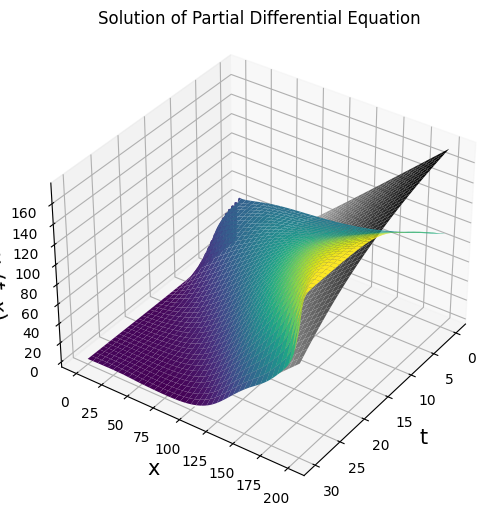

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 200
tspace = np.linspace(tmin, tmax, N + 1)
xspace = np.linspace(xmin, xmax, N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Actual Values
uact = U(X,T)
# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,'float32'))

# Reshape upred
U_pred = upred.numpy().reshape(N+1,N+1)
U_act = uact.reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U_act, cmap='binary');
ax.plot_surface(T, X, U_pred, cmap='viridis');
# ax.plot_surface(T, X, U_act, cmap='binary');
ax.view_init(35,35)
ax.set_xlabel('t',fontsize=15)
ax.set_ylabel('x',fontsize=15)
ax.set_zlabel('$u_\\theta(t,x)$',fontsize=15,rotation=90)
ax.set_title('Solution of Partial Differential Equation');

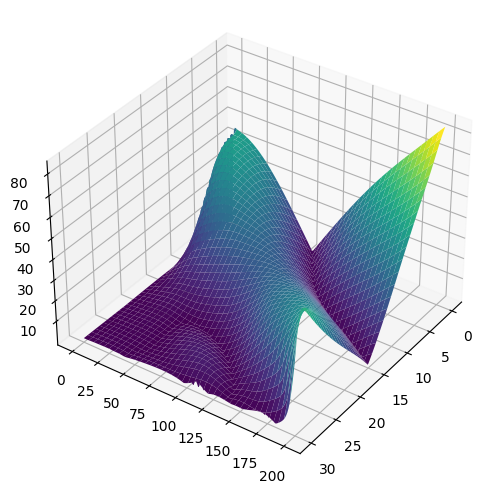

In [ ]:
diff = np.abs(U_act - U_pred)
# diff = np.sqrt(diff[0]**2 + diff[1]**2)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, diff, cmap='viridis');
ax.view_init(35,35)

# Plotting Loss

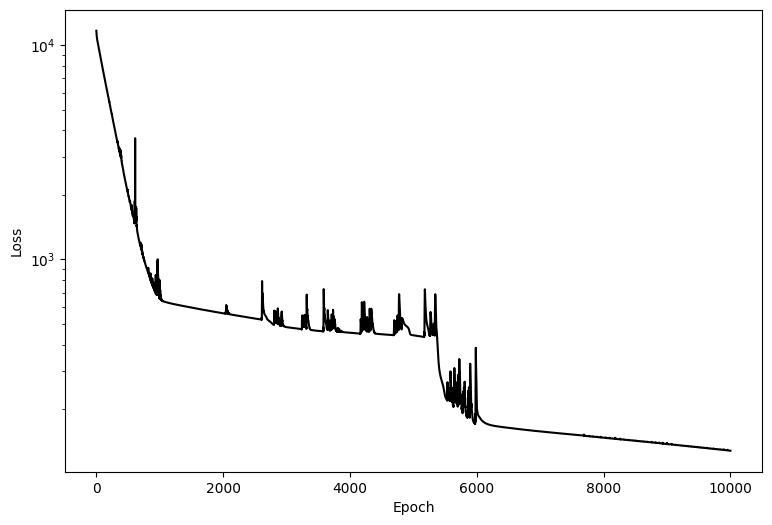

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss');